In [5]:
import csv
import os
import numpy as np
import string
import matplotlib.pyplot as plt
import pickle
import random
from collections import defaultdict
from dataclasses import dataclass
from zipfile import ZipFile
import pandas as pd
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
from sklearn.model_selection import KFold, train_test_split
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benjamin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
data_path = 'training.1600000.processed.noemoticon.csv'

@dataclass
class CONFIG():
  """
  """
  col_names = ["target", "ids", "date", "flag", "user", "text"]
  embedding_dim = 300
  maxlen = 50
  vocab_size = 200000
  truncating = 'post'
  padding = 'post'
  oov_token = '<OOV>'
  max_examples = 160000
  training_split = .9

Config = CONFIG()

data = pd.read_csv(data_path,
                   names = CONFIG.col_names,
                   encoding = "ISO-8859-1")

print('Dataset size {}'.format(len(data)))
print('Dataset first five rows:\n{}'.format(data.head()))

Dataset size 1600000
Dataset first five rows:
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


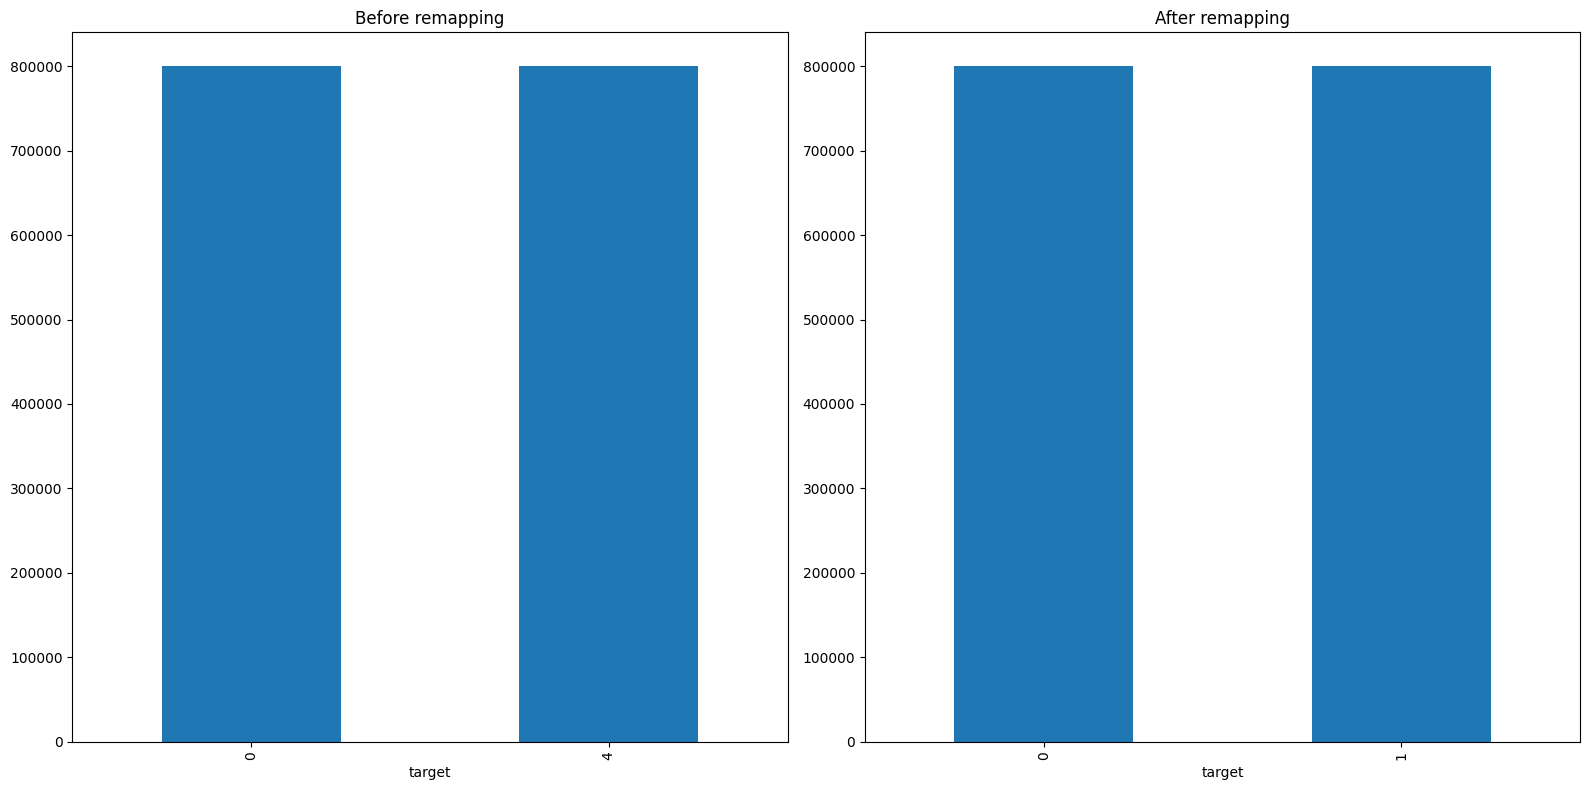

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2,
                               figsize = (16, 8))

data.target.value_counts().plot(kind = 'bar', ax = ax1)
ax1.set_title('Before remapping')
data.target = data.target.map({0 : 0,
                               4 : 1})
data.target.value_counts().plot(kind = 'bar', ax = ax2)
ax2.set_title('After remapping')
plt.tight_layout() 

In [9]:
# Sample text to check appearance of special characters
stop_words = stopwords.words('english')
porter = nltk.stem.PorterStemmer()
remove_links = "https?:\S+|http?:\S|[0-9]+"
rep_elipse = "\.{2,}"
stop_list = stop_words + list(string.punctuation)

In [10]:
def preprocess_tweet(tweet: str, 
                     stemmer: object,
                     remove_links_regex,
                     reduce_elipses_regex):
  """
  """
  tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,
                                                 reduce_len=True)
  # remove links and numbers
  
  tweet = re.sub(remove_links_regex, '', str(tweet))
  # Tokenize 
  tweet = tweet_tokenizer.tokenize(tweet)
  # Remove stop words
  tweet = [stemmer.stem(token.lower().strip()) for token in tweet if token not in stop_list]
  tweet =  ' '.join(tweet)

  # Replace elipse (two or more .. with ..)
  tweet = re.sub(reduce_elipses_regex, '..', str(tweet))
  
  return tweet

In [11]:
test = data.head()
test = test['text'].apply(lambda x: preprocess_tweet(x, porter, remove_links, rep_elipse))
print('Before: {}'. format(list(data['text'][:5])))
print('After: {}'. format(list(test[:5])))

Before: ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 'my whole body feels itchy and like its on fire ', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
After: ["awww that' bummer you shoulda got david carr third day ;d", "upset can't updat facebook text .. might cri result school today also blah", 'i dive mani time ball manag save the rest go bound', 'whole bodi feel itchi like fire', "behav i'm mad i can't see"]


In [12]:
def preprocess_tweet_df(dd:object):
  """
  """
  dd['text'] = data['text'].map(lambda tweet: preprocess_tweet(tweet, 
                                                               porter,
                                                               remove_links,
                                                               rep_elipse))

  return dd

In [13]:
data = data.drop(['ids', 'date', 'flag','user'], axis = 1)

In [14]:
# now I want to apply the preprocessing to the entire dataset, save it and then load it
data = preprocess_tweet_df(data)
data.to_csv('preprocessed_tweets.csv', index = False)
data = pd.read_csv('preprocessed_tweets.csv')